In [168]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import random
import requests
from sklearn import linear_model
import warnings
from scipy import stats
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

### OrderChain Class

In [235]:
class OrderChain:
    def __init__(self, time, qty, timeLength, histData, bps = 50, bpsFunc = None, regr = None):
        self.bpsUsed = None
        self.qty = qty
        self.histData = self.getHistData(time, timeLength, histData)
        self.orderData = self.getChainTrades(bps, bpsFunc, regr)

    
    def getHistData(self, time, timeLength, histData):
        end = time +  datetime.timedelta(seconds=np.ceil(timeLength*60*24*365)*60)
        return histData.loc[time:end]
    
    def getChainTrades(self, bps, bpsFunc, regr):
        
        if self.histData.empty:
            return None
        
        chain = pd.DataFrame(columns = ['Timestamp', 'Price', 'Qty'])
        chain = self.addFirstTrade(chain, self.histData.iloc[0])
        
        if bpsFunc is not None:
            return self.bpsFuncTrade(chain, bpsFunc, bps, regr)
        else:
            return self.bpsTrade(chain, bps)
    
    def bpsTrade(self, chain, bps):
        lastTradePrice = chain.head(1).Price.values[0]
        
        for row in self.histData.iterrows():
            currPrice = float(row[1].close)
            bpsChange = (abs(currPrice - lastTradePrice)/lastTradePrice)*10000
            if bpsChange > bps:
                chain = self.addTrade(chain, row)
                lastTradePrice = currPrice
                
        return chain
    
    def bpsFuncTrade(self, chain, bpsFunc, bps, regr):
        
        lastTradePrice = chain.head(1).Price.values[0]
        
        bpsToTrade = 50
        
        bpsUsed = []
        bpsUsed.append(bpsToTrade)
        
        for row in self.histData.iterrows():
            
            newBps = bpsFunc(row, regr)
            if newBps is not None:
                bpsToTrade = newBps
            bpsUsed.append(bpsToTrade)
            
            currPrice = float(row[1].close)
            bpsChange = (abs(currPrice - lastTradePrice)/lastTradePrice)*10000
            
            if bpsChange > bpsToTrade:
                chain = self.addTrade(chain, row)
                lastTradePrice = currPrice
                
        self.bpsUsed = np.mean(bpsUsed)
        return chain
    
    def addTrade(self, chain, row):
        chain.loc[len(chain.index)] = {'Timestamp' : pd.to_datetime(row[1].datetime).to_pydatetime(), 'Price': float(row[1].close), 'Qty':self.qty}
        return chain
        
    def addFirstTrade(self, chain, dataRow):
        chain.loc[len(chain.index)] = {'Timestamp' :pd.to_datetime(dataRow.datetime).to_pydatetime(), 'Price': float(dataRow.close), 'Qty':self.qty}
        return chain

### Get historical order data and generate random trade data

In [5]:
def orderData():
    #
    #Scrape data on order chain time lengths/quantities

    #Import and cleanse data
    fileName = 'OriginalDataSet.csv' #Can't be made public since it included Genesis's trades
    df = pd.read_csv(fileName, dtype = 'str')
    df.dropna(how='all', axis=1, inplace=True)
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df.drop(cols_to_drop, axis=1, inplace=True)
    delCols = ['Symbol', 'ClOrdID', 'OrigClOrdID', 'SubmitTime', 'ExecID', 'TransactTime', 'CumFee', \
               'SubAccount', 'Strategy', 'OrdType', 'Revision', 'LastRequestTimestamp', 'Text', \
              'Parameters', 'Allocation']
    df.drop(delCols, axis=1, inplace=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df[['Group', 'Parent']] = df['Group'].str.split('/', 1, expand=True)
    df[['Parent', 'LastInChain']] = df['Parent'].str.split('/', 1, expand=True)

    #Choose BTC for vol calculations
    btcFills = df.loc[df['Symbol.1'] == 'BTC']

    #Group orders by parentID
    df = df.sort_values(by=['Parent'])
    #Dict for parentID groups
    parentDict = {}
    for ind in df.index:
        parentID = df['Parent'][ind]
        if parentID == None:
            continue
        if parentID in parentDict.keys():
            parentDict[parentID].append(ind)
        else:
            parentDict[parentID] = [ind]

    #Add parent to parentID group
    for ind in df.index:
        orderID = df['OrderID'][ind]
        if orderID in parentDict.keys():
            parentDict[orderID].append(ind)

    #Create new dict with order chains of 3+ transactions
    chainDict = {}
    for key in parentDict.keys():
        n = len(parentDict[key])
        if n > 2:
            chainDict[key] = parentDict[key]
            
    #Parse through each order chain and calculate annnualized captured vol
    secInYear = 365*24*60*60
    qty = []
    timeOpen = []
    for key in chainDict.keys():
        #Data cleanse
        chain = df.loc[chainDict[key]][['Timestamp', 'Side', 'CumQty', 'AvgPxAllIn', 'Parent']]
        chain = chain.sort_values(by='Timestamp',ascending=True)
        chain['AvgPxAllIn'] = chain['AvgPxAllIn'].astype('float')
        chain['CumQty'] = chain['CumQty'].astype('float')
        chain['tDelta'] = chain['Timestamp'].diff()/np.timedelta64(1, 's')/secInYear
        qty.append(chain.CumQty.mean())
        timeOpen.append(chain.tDelta.sum())
    
    #Get start and end times
    df = df.sort_values(by='Timestamp',ascending=True)
    
    return qty, timeOpen

### Historical Data Scraper

In [6]:
## Import price history
def getReqDate(d):
    
    start = pd.to_datetime(d)
    sYear = str(start.year)
    sMonth = ""
    sDay = ""
    
    if(start.month <10):
        sMonth = "0"+ str(start.month)
    else:
        sMonth = str(start.month)
    
    if(start.day <10):
        sDay = "0"+ str(start.day)
    else:
        sDay = str(start.day)
    
    output = sYear+sMonth+sDay+"T000000"
    return output

def getData(start,end,timeFrame,pair):
    access_token = ""
    headers = {'Authorization': 'Bearer ' + access_token}
    fromDate = getReqDate(start)
    toDate = getReqDate(end)
    url = "https://api.cryptoquant.com/v1/"+pair+"/market-data/price-ohlcv?window="+timeFrame+"&from="+fromDate+"&to="+toDate+"&limit=100000"
    temp = pd.DataFrame(requests.get(url, headers=headers).json()['result']['data'])
    temp.sort_values(by = 'datetime',inplace=True)
    temp.index = pd.to_datetime(temp.datetime)
    check = pd.to_datetime(temp.index[0])
    check1 = pd.to_datetime(start)
    if check.year != check1.year or check.month != check1.month or check.day != check1.day:
        newEnd = check
        #print(newEnd)
        newDF = pd.concat([getData(start,newEnd,timeFrame,pair), temp])
        dupIndex = newDF.index.duplicated(keep="first")
        newDF = newDF[~dupIndex]
        newDF.sort_index(inplace=True)
        
        return newDF
    else:
        return temp


### Captured Vol Calculator

In [179]:
def capturedVol(orderChains):   
    #Parse through each order chain and calculate annnualized captured vol
    secInYear = 365*24*60*60
    #returnsData = pd.DataFrame(columns = ['tDeltaSqrt', 'tDelta', 'logReturns'])
    volCalc = pd.DataFrame({'logReturns' : [], 'tDelta' : []})
    for orderChain in orderChains:
        
        chain = orderChain.orderData
        if chain is None:
            continue
        
        chain = chain.sort_values(by='Timestamp')
        chain['tDelta'] = (chain['Timestamp']-chain['Timestamp'].shift(1)).dt.seconds/secInYear
        chain['logReturns'] = np.log(chain['Price']) - np.log(chain['Price'].shift(1))
        chain = chain[['logReturns', 'tDelta']].dropna()
        volCalc = pd.concat([volCalc, chain])
        '''
        try:
            if len(chain.index) < 2:
                continue
        except:
            continue  
        #Captured vol calculations
        chain['range'] = (np.log(chain.Price) - np.log(chain.Price.shift(1)))/np.sqrt((chain.Timestamp - chain.Timestamp.shift(1))/np.timedelta64(1, 's')/secInYear)
        chain['tDelta'] = np.sqrt((chain.Timestamp - chain.Timestamp.shift(1))/np.timedelta64(1, 's')/secInYear)
        chain = chain[['range', 'tDelta']].dropna()
        returnsData = pd.concat([returnsData, chain])
        '''
    volCalc['range'] = volCalc['logReturns']/np.sqrt(volCalc['tDelta'])
    volCalc.replace([np.inf, -np.inf], np.nan, inplace=True)
    volCalc = volCalc.dropna()
    volCalc = volCalc[(np.abs(stats.zscore(volCalc)) < 3).all(axis=1)]    
    capVol = volCalc.range.std()/np.sqrt(365/np.sqrt(volCalc.tDelta).sum())
    return capVol, returnsData

### Modeling Regression Function

In [8]:
# Add the necessary data to the historical data

def addExternalData(df):
    
    # Exchange Inflows
    inflow = pd.read_csv('BTCInflow.csv')
    inflow['Datetime'] = pd.to_datetime(inflow['Datetime'])
    inflow['Inflow'] = pd.to_numeric(inflow['Inflow'])
    inflow.drop_duplicates('Datetime',keep='last')
    
    # Leverage
    lev = pd.read_csv('BTCestLev.csv')
    lev['Datetime'] = pd.to_datetime(lev['Datetime'])
    lev['lev'] = pd.to_numeric(lev['estLev'])
    lev.drop_duplicates('Datetime',keep='last')
    
    # Open interest
    oi = pd.read_csv('BTCopenInterest.csv')
    oi['Datetime'] = pd.to_datetime(oi['Datetime'])
    oi['openInterest'] = pd.to_numeric(oi['openInterest'])
    oi.drop_duplicates('Datetime',keep='last')
    
    # Add data to hist data
    df['inflow'] = np.nan
    df['lev'] = np.nan
    df['openInterest'] = np.nan

    for i, row in df.iterrows():
        hourRound = i.replace(second=0, microsecond=0, minute=0, hour=i.hour) + datetime.timedelta(hours=i.minute//30)
        if hourRound in inflow.Datetime.values:
            df.at[i, 'inflow'] = inflow.loc[inflow.Datetime.values == hourRound].Inflow
        if hourRound in lev.Datetime.values:
            df.at[i, 'lev'] = lev.loc[lev.Datetime.values == hourRound].lev
        if hourRound in oi.Datetime.values:
            df.at[i, 'openInterest'] = oi.loc[oi.Datetime.values == hourRound].openInterest
            
    return df

In [9]:
def getRegression(df):
    df["logReturn"] = np.log(df.close) - np.log(df.close.shift(1))
    df["vol"] = df['logReturn'].rolling(60).std()*(60*24*365)**0.5
    dataSet = df[['volume', 'inflow', 'openInterest', 'lev', 'vol']].dropna()
    X = dataSet[['volume', 'inflow', 'openInterest', 'lev']]
    X = X.iloc[:-1]
    y = dataSet['vol'].shift(-1).dropna()
    regr = linear_model.LinearRegression()
    regr = regr.fit(X.values, y)
    return regr, regr.score(X, y)

### Strategy Testing

In [229]:
qty, timeOpen = orderData()

# Set number of chains to create
n = 500

startTime = datetime.date(2022, 1, 1)
endTime = datetime.date(2022, 3, 15)

# Generate random data
randomTimeLengths = abs(np.mean(timeOpen) + (np.random.rand(n)-0.5)*np.std(timeOpen))
randomQty = abs(np.mean(qty) + (np.random.rand(n)-0.5)*np.std(qty))
times = pd.date_range(start = startTime, end = endTime, freq = 'min').to_pydatetime().tolist()
times = random.sample(times, n)

In [230]:
histData = getData(startTime.strftime('%Y-%m-%d'), endTime.strftime('%Y-%m-%d'), 'min', 'btc')

In [231]:
histData = addExternalData(histData)
histData["logReturn"] = np.log(histData.close) - np.log(histData.close.shift(1))
histData["vol"] = histData['logReturn'].rolling(60).std()*(60*24*365)**0.5

In [216]:
histData.to_csv('HistoricalDataWithMetrics.csv')

In [233]:
regr, score = getRegression(histData)

C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [223]:
def bpsFunc(row, regr):
    try:
        bps = regr.predict([[row[1].volume, row[1].inflow, row[1].openInterest, row[1].lev]])
        return bps[0]*60
    except:
        return None

In [697]:
orderChains = []
for i in range(n):
    chain = OrderChain(times[i], randomQty[i], randomTimeLengths[i], histData, bps=300)
    orderChains.append(chain)

In [205]:
capVol, returnsData = capturedVol(orderChains)
print("Mean annualized captured volatility: " + str(round(capVol*100, 3)) + "%")

Mean annualized captured volatility: 15.686%


### Create and plot cap vol as a function of bps

In [28]:
def getCapVols(bpsRange):
    capVols = []
    for bps in bpsRange:
        orderChains = []
        for i in range(n):
            chain = OrderChain(times[i], randomQty[i], randomTimeLengths[i], histData, bps=bps)
            orderChains.append(chain)
        capVol, _ = capturedVol(orderChains)
        print("Mean annualized captured volatility: " + str(round(capVol*100, 3)) + "%")
        capVols.append(capVol)
    return capVols

In [189]:
bpsRange = range(10, 210, 10)
capVols = getCapVols(bpsRange)
print(bpsRange)
print(capVols)

Mean annualized captured volatility: 82.665%
Mean annualized captured volatility: 79.924%
Mean annualized captured volatility: 76.353%
Mean annualized captured volatility: 72.889%
Mean annualized captured volatility: 69.885%
Mean annualized captured volatility: 66.662%
Mean annualized captured volatility: 62.463%
Mean annualized captured volatility: 60.032%
Mean annualized captured volatility: 57.566%
Mean annualized captured volatility: 59.192%
Mean annualized captured volatility: 54.148%
Mean annualized captured volatility: 52.196%
Mean annualized captured volatility: 51.592%
Mean annualized captured volatility: 47.794%
Mean annualized captured volatility: 46.154%
Mean annualized captured volatility: 43.716%
Mean annualized captured volatility: 43.403%
Mean annualized captured volatility: 41.101%
Mean annualized captured volatility: 37.706%
Mean annualized captured volatility: 36.855%
range(10, 210, 10)
[0.8266515035560179, 0.7992411611473703, 0.7635283214910041, 0.7288917990659454, 

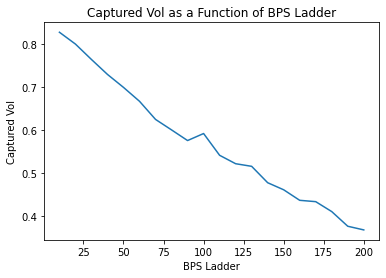

In [217]:
plt.plot(bpsRange, capVols)
plt.title('Captured Vol as a Function of BPS Ladder')
plt.xlabel('BPS Ladder')
plt.ylabel('Captured Vol')
plt.show()

### Create regression model and plot as function of constant C (updating bps each minute)

In [107]:
def getRegressionCapVols(cRange):
    capVols = []
    bpsAvgs = []
    for C in cRange:
        def bpsFunc(row, regr):
            try:
                bps = regr.predict([[row[1].volume, row[1].inflow, row[1].openInterest, row[1].lev]])
                return abs(1-bps[0])*C
            except:
                return None

        orderChains = []
        bpsUsed = []
        for i in range(n):
            chain = OrderChain(times[i], randomQty[i], randomTimeLengths[i], histData, bpsFunc=bpsFunc, regr = regr)
            orderChains.append(chain)
            bpsUsed.append(chain.bpsUsed) 
            
        capVol, _ = capturedVol(orderChains)
        bpsUsed = list(filter(None, bpsUsed))
        bpsAverage = np.mean(bpsUsed)
        print("Average bps used: " + str(round(bpsAverage, 2)))
        print("Mean annualized captured volatility: " + str(round(capVol*100, 3)) + "%")
        capVols.append(capVol)
        bpsAvgs.append(bpsUsed)
        
    return capVols, bpsAvgs

In [234]:
cRange = range(40, 320, 20)
regressionCapVols, regressionAvgBpsUsed = getRegressionCapVols(cRange)
print(regressionCapVols)
print(regressionAvgBpsUsed)

UnboundLocalError: local variable 'row' referenced before assignment

In [195]:
cRange = range(40, 320, 20)
regressionCapVolsNoAutoUpdate, regressionAvgBpsUsedNoAutoUpdate = getRegressionCapVols(cRange)
print(regressionCapVolsNoAutoUpdate)
print(regressionAvgBpsUsedNoAutoUpdate)

Average bps used: 16.14
Mean annualized captured volatility: 79.486%
Average bps used: 24.05
Mean annualized captured volatility: 76.391%
Average bps used: 31.96
Mean annualized captured volatility: 72.908%
Average bps used: 39.87
Mean annualized captured volatility: 70.862%
Average bps used: 47.78
Mean annualized captured volatility: 68.19%
Average bps used: 55.69
Mean annualized captured volatility: 65.673%
Average bps used: 63.6
Mean annualized captured volatility: 64.884%
Average bps used: 71.51
Mean annualized captured volatility: 62.845%
Average bps used: 79.42
Mean annualized captured volatility: 61.528%
Average bps used: 87.33
Mean annualized captured volatility: 60.024%
Average bps used: 95.24
Mean annualized captured volatility: 58.057%
Average bps used: 103.15
Mean annualized captured volatility: 57.878%
Average bps used: 111.06
Mean annualized captured volatility: 57.255%
Average bps used: 118.97
Mean annualized captured volatility: 56.679%
[0.7948607265356148, 0.7639091349

In [196]:
bpsRegrCont = []
for bpsList in regressionAvgBpsUsed:
    bpsRegrCont.append(np.mean(bpsList))
    
bpsRegrNoCont = []
for bpsList in regressionAvgBpsUsedNoAutoUpdate:
    bpsRegrNoCont.append(np.mean(bpsList))
    
print(regressionCapVols)
print(bpsRegrCont)
print(regressionCapVolsNoAutoUpdate)
print(bpsRegrNoCont)

[0.7948607265356148, 0.7639091349324499, 0.7290754216069604, 0.7086231903529645, 0.6818991585542196, 0.6567345640983597, 0.6488426092710773, 0.6284511537144799, 0.6152774400379225, 0.6002422830422224, 0.5805737207830196, 0.5787815673990576, 0.5725484672133642, 0.5667916519647266]
[16.136685055527597, 24.04665447522605, 31.956623894924505, 39.86659331462296, 47.776562734321416, 55.686532154019865, 63.596501573718314, 71.50647099341677, 79.41644041311523, 87.32640983281368, 95.23637925251214, 103.14634867221059, 111.05631809190903, 118.9662875116075]
[0.7586069622177443, 0.7016522335450113, 0.653688100157902, 0.6003433582490258, 0.5756558694752455, 0.5471000255189717, 0.5083953644305965, 0.4756078697949529, 0.44572875003086143, 0.4386619535979753, 0.4095288197862212, 0.3949714447584562, 0.37616038330978163, 0.38151030965801064]
[17.328311620292375, 23.142454641138606, 28.728601247443915, 35.114984988228244, 41.317307644025135, 48.575469792499895, 56.81832600323293, 62.236757323025024, 69

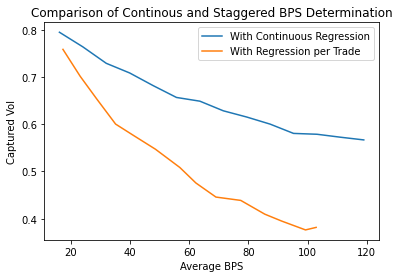

In [197]:
plt.plot(bpsRegrCont, regressionCapVols, label = "With Continuous Regression")
plt.plot(bpsRegrNoCont, regressionCapVolsNoAutoUpdate, label = "With Regression per Trade")
plt.legend()
plt.title('Comparison of Continous and Staggered BPS Determination')
plt.xlabel('Average BPS')
plt.ylabel('Captured Vol')
plt.show()

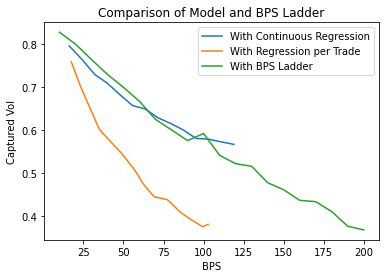

In [198]:
plt.plot(bpsRegrCont, regressionCapVols, label = "With Continuous Regression")
plt.plot(bpsRegrNoCont, regressionCapVolsNoAutoUpdate, label = "With Regression per Trade")
plt.plot(bpsRange, capVols, label = "With BPS Ladder")
plt.legend()
plt.title('Comparison of Model and BPS Ladder')
plt.xlabel('BPS')
plt.ylabel('Captured Vol')
plt.show()

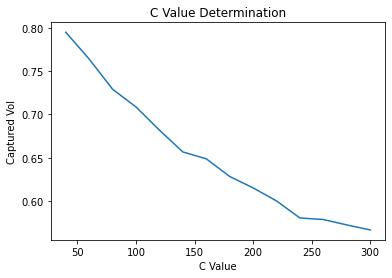

In [236]:
plt.plot(cRange, regressionCapVols, label = "With BPS Ladder")
#plt.legend()
plt.title('C Value Determination')
plt.xlabel('C Value')
plt.ylabel('Captured Vol')
plt.show()

In [227]:
capVol, returnsData = capturedVol(orderChains)
print("Mean annualized captured volatility: " + str(round(capVol*100, 3)) + "%")

Mean annualized captured volatility: 38.535%


### Test on their data

In [226]:
#Import and cleanse data
fileName = 'OriginalDataSet.csv'  #Can't be made public since it included Genesis's trades
df = pd.read_csv(fileName, dtype = 'str')
df.dropna(how='all', axis=1, inplace=True)
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1, inplace=True)
delCols = ['Symbol', 'ClOrdID', 'OrigClOrdID', 'SubmitTime', 'ExecID', 'TransactTime', 'CumFee', \
           'SubAccount', 'Strategy', 'OrdType', 'Revision', 'LastRequestTimestamp', 'Text', \
          'Parameters', 'Allocation']
df.drop(delCols, axis=1, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df[['Group', 'Parent']] = df['Group'].str.split('/', 1, expand=True)
df[['Parent', 'LastInChain']] = df['Parent'].str.split('/', 1, expand=True)

#Choose BTC for vol calculations
df = df.loc[df['Symbol.1'] == 'BTC']

#Group orders by parentID
df = df.sort_values(by=['Parent'])

#Dict for parentID groups
parentDict = {}
for ind in df.index:
    parentID = df['Parent'][ind]
    if parentID == None:
        continue
    if parentID in parentDict.keys():
        parentDict[parentID].append(ind)
    else:
        parentDict[parentID] = [ind]

#Add parent to parentID group
for ind in df.index:
    orderID = df['OrderID'][ind]
    if orderID in parentDict.keys():
        parentDict[orderID].append(ind)
        
orderChains = []

for key in parentDict.keys():
    chain = df.loc[parentDict[key]][['Timestamp', 'Side', 'CumQty', 'AvgPxAllIn', 'Parent']]
    chain = chain.sort_values(by='Timestamp',ascending=True)
    chain['AvgPxAllIn'] = chain['AvgPxAllIn'].astype('float')
    chain['CumQty'] = chain['CumQty'].astype('float')
    time = chain.iloc[0].Timestamp
    time = time.replace(second=0, microsecond=0, minute=time.minute) + datetime.timedelta(minutes=time.second//30)
    timeLast = chain.iloc[-1].Timestamp
    timeLast = timeLast.replace(second=0, microsecond=0, minute=timeLast.minute) + datetime.timedelta(minutes=timeLast.second//30)
    timeLength = (timeLast - time).total_seconds()/(60*60*24*365)
    qty = chain.CumQty.mean()
    chain = OrderChain(time, qty, timeLength, histData, bps=25)
    orderChains.append(chain)

C:\Users\TBaker\AppData\Local\Temp\ipykernel_19616\1852696481.py:11: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return histData.loc[time:end]
C:\Users\TBaker\AppData\Local\Temp\ipykernel_19616\1852696481.py:11: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return histData.loc[time:end]
C:\Users\TBaker\AppData\Local\Temp\ipykernel_19616\1852696481.py:11: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return histData.loc[time:end]
C:\Users\TBaker\AppData\Local\Temp\ipykernel_19616\1852696481.py:11: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware da

# orderChain